<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(2021_12_13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第10回）**##

（執筆中）
時系列観測データから、数理モデルのパラメータをベイズ推定


Sequential MonteCarlo (SMC);
Approximated Bayesian Computation (ABC);

パラメータ値$\theta$を入れてシミュレーションする。とにかくたくさんやる。データ$y$に近いところだけ集めてきて、いい感じに、パラメータ値の事後分布$p(\theta|y)$を作る。計算機の力で押し切る。

**解説**

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [2]:
from scipy.integrate import odeint

# ロトカ・ボルテラ方程式

# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10.0, 5.0]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])


# simulator function
def competition_model(a, b, c,d):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))

In [3]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(a, b, c, d) + noise
    return simulated

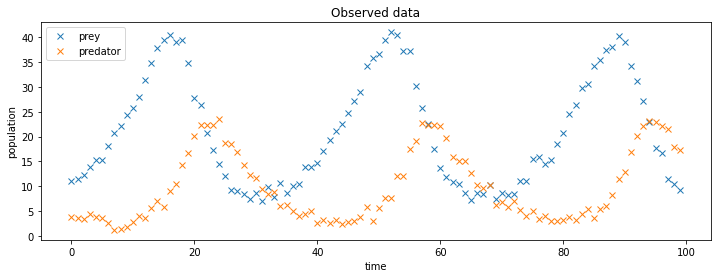

In [4]:
# plotting observed data.
observed = add_noise(a, b, c, d)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(observed[:, 0], "x", label="prey")
ax.plot(observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

In [5]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0) ##非負値
    b = pm.HalfNormal("b", 1.0) ##非負値
    c = pm.HalfNormal("c", 1.0) ##非負値
    d = pm.HalfNormal("d", 1.0) ##非負値

    sim = pm.Simulator("sim", competition_model, params=(a, b, c, d), epsilon=10, observed=observed)

    trace_lv = pm.sample_smc(kernel="ABC", parallel=True)
    idata_lv = az.from_pymc3(trace_lv)

Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 0.010
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/pymc3/distributions/simulator.py:146: RuntimeWarning: overflow encountered in square
  return -0.5 * ((obs_data - sim_data) / epsilon) ** 2
Stage:   1 Beta: 0.019
Stage:   2 Beta: 0.031
Stage:   3 Beta: 0.050
Stage:   4 Beta: 0.103
Stage:   5 Beta: 0.227
Stage:   6 Beta: 0.505
Stage:   7 Beta: 1.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3963f639d0>,
      dtype=object)

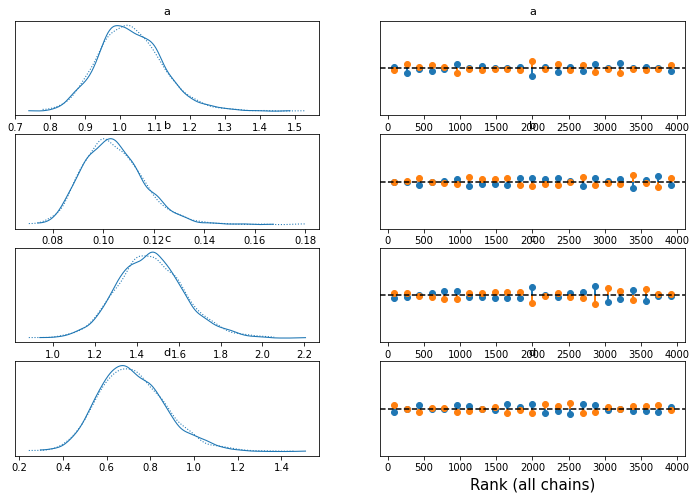

In [9]:
az.plot_trace(idata_lv, kind="rank_vlines")

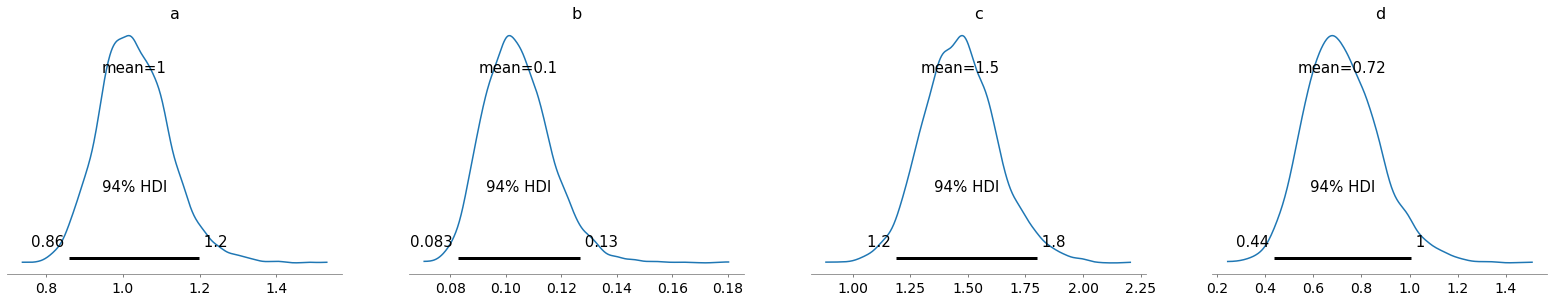

In [6]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata_lv)

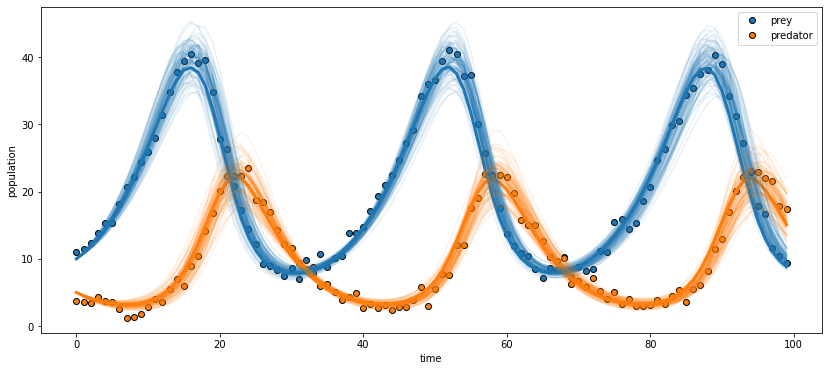

In [7]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")
ax.plot(competition_model(trace_lv["a"].mean(), trace_lv["b"].mean(), trace_lv["c"].mean(), trace_lv["d"].mean()), linewidth=3)
for i in np.random.randint(0, len(trace_lv), 100):
    sim = competition_model(trace_lv["a"][i], trace_lv["b"][i], trace_lv["c"][i], trace_lv["d"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

In [8]:
print("a",trace_lv["a"].mean())
print("b",trace_lv["b"].mean())
print("c",trace_lv["c"].mean())
print("d",trace_lv["d"].mean())

a 1.03081008125741
b 0.1043158282607153
c 1.466693986765803
d 0.7196904482822992
